### Getting the data

For this homework, we will use the **lead scoring Bank Marketing** dataset:

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-08 16:40:19--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.001s  

2025-10-08 16:40:20 (57.3 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.

### Data preparation

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
leading_score = pd.read_csv("course_lead_scoring.csv")
leading_score.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


- Check if the missing values are presented in the features.

- If there are missing values:
    - For caterogiral features, replace them with `NA`

    - For numerical features, replace with with `0.0`

In [3]:
# Check for missing values
leading_score.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Only 4 features do not have missing values while other important features lack a decent amount of entries.

In [4]:
# Fill missing values for categorical and numerical features
for col in leading_score.columns:
    if leading_score[col].dtype == 'object':
        leading_score[col] = leading_score[col].fillna('NA')
    else:
        leading_score[col] = leading_score[col].fillna(0.0)


### Question 1

In [5]:
# Check for mode value in industry column
leading_score['industry'].mode()[0] 

'retail'

What is the most frequent observation (mode) for the column `industry`? **retail**

### Question 2

Create the **correlation matrix** for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

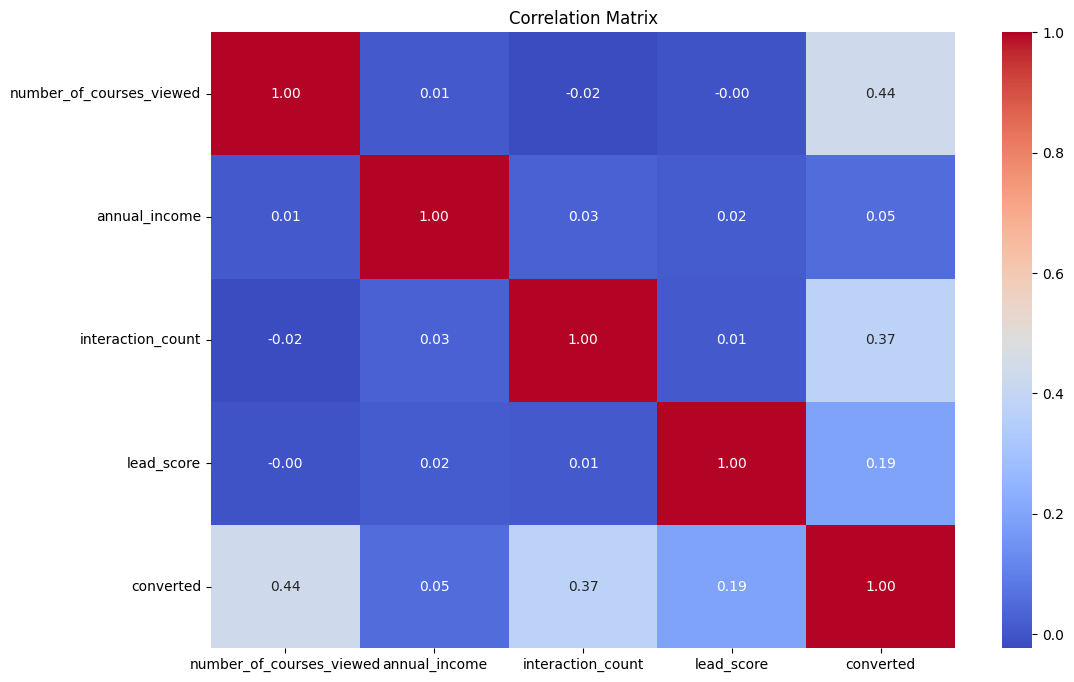

In [6]:
# Create correlation matrix
corr_matrix = leading_score[leading_score.select_dtypes(exclude=['object']).columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

What are the two features that have the biggest correlation? **`annual_income` and `interaction_count`**

### Split the data

- Split your data in train/val/test sets with 60%/20%/20% distribution.

- Use Scikit-Learn for that (the `train_test_split` function) and set the seed to 42.

- Make sure that the target value `y` is not in your dataframe.

In [7]:
#  Split the data
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(leading_score, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 3

Calculate the mutual information score between `y` and other categorical variables in the dataset. Use the **_training set_** only.

Round the scores to 2 decimals using `round(score, 2)`.

In [8]:
# Calculate the mutual information score 
from sklearn.metrics import mutual_info_score

cat = df_train.select_dtypes(include=['object']).columns
mi_scores = {}

for col in cat:
    mi = mutual_info_score(df_train[col], y_train)
    mi_scores[col] = round(mi, 2)
    # Display categotical features and their MI scores
    print(f"{col}: {round(mi, 2)}")

lead_source: 0.04
industry: 0.01
employment_status: 0.01
location: 0.0


Which of these variables has the biggest mutual information score? `lead_source`

### Question 4

Now let's train a logistic regression:

- Include categorical variables using one-hot encoding.

- Fit the model on the training dataset.

    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:

    - `model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)`

- Calculate the accuracy on the **validation dataset** and round it to 2 decimal digits.

In [ ]:
# Apply StandardScaler to numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num = df_train.select_dtypes(exclude=['object']).columns
X_train_num = scaler.fit_transform(df_train[num])
X_val_num = scaler.transform(df_val[num])
X_test_num = scaler.transform(df_test[num])

In [19]:
# Apply OneHotEncoder to categorical features
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(df_train[cat])
X_val_cat = ohe.transform(df_val[cat])
X_test_cat = ohe.transform(df_test[cat])

cat_ohe = ohe.get_feature_names_out(cat)

In [12]:
# Combine numerical and categorical features
X_train_final = np.hstack([X_train_num, X_train_cat])
X_val_final = np.hstack([X_val_num, X_val_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])

In [ ]:
# Train a logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_final, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
# Evaluate the model
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val_final)
accuracy = accuracy_score(y_val, y_pred)

print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 0.85


What accuracy did you get? **0.84**

### Question 5

Let's find the least useful feature using the _feature elimination_ technique.

- Train a model using the same features and parameters as in Q4 (without rounding).

- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.

- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

In [43]:
# Exclude each feature and evaluate the model
base_accuracy = accuracy
feature_importance = {} 

for i, col in enumerate(num.tolist() + cat_ohe.tolist()):
    # Remove column i
    X_train_drop = np.delete(X_train_final, i, axis=1)
    X_val_drop = np.delete(X_val_final, i, axis=1)

    model.fit(X_train_drop, y_train)
    y_pred = model.predict(X_val_drop)

    temp_accuracy = accuracy_score(y_val, y_pred)
    diff = base_accuracy - temp_accuracy
    feature_importance[col] = diff

    print(f"Excluding {col}: Accuracy = {temp_accuracy:.4f}, Difference = {diff:.4f}")

Excluding number_of_courses_viewed: Accuracy = 0.7372, Difference = 0.1160
Excluding annual_income: Accuracy = 0.8532, Difference = 0.0000
Excluding interaction_count: Accuracy = 0.7713, Difference = 0.0819
Excluding lead_score: Accuracy = 0.8191, Difference = 0.0341
Excluding lead_source_NA: Accuracy = 0.8532, Difference = 0.0000
Excluding lead_source_events: Accuracy = 0.8532, Difference = 0.0000
Excluding lead_source_organic_search: Accuracy = 0.8532, Difference = 0.0000
Excluding lead_source_paid_ads: Accuracy = 0.8498, Difference = 0.0034
Excluding lead_source_referral: Accuracy = 0.8532, Difference = 0.0000
Excluding lead_source_social_media: Accuracy = 0.8567, Difference = -0.0034
Excluding industry_NA: Accuracy = 0.8532, Difference = 0.0000
Excluding industry_education: Accuracy = 0.8498, Difference = 0.0034
Excluding industry_finance: Accuracy = 0.8532, Difference = 0.0000
Excluding industry_healthcare: Accuracy = 0.8532, Difference = 0.0000
Excluding industry_manufacturing: A

In [47]:
# Find the feature with the smallest difference (the least useful)
min_feature = min(feature_importance, key=feature_importance.get)
print(f"Feature with the smallest difference: {min_feature} with a difference of {feature_importance[min_feature]}")

Feature with the smallest difference: lead_source_social_media with a difference of -0.0034129692832763903


Which of following feature has the smallest difference? `lead_source`

### Question 6

Now let's train a regularized logistic regression.
- Let's try the following values of the parameter `C`: `[0.01, 0.1, 1, 10, 100]`.

- Train models using all the features as in Q4.

- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

In [ ]:
c = [0.01, 0.1, 1, 10, 100]

# Find the best C value for the logistic regression model
best_c = None
best_accuracy = 0   

for c in c:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_val_final)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"C={c}: Validation Accuracy = {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_c = c

C=0.01: Validation Accuracy = 0.8395904436860068
C=0.1: Validation Accuracy = 0.856655290102389
C=1: Validation Accuracy = 0.8532423208191127
C=10: Validation Accuracy = 0.8532423208191127
C=100: Validation Accuracy = 0.8532423208191127


In [28]:
# Print the best C value
print(f"Best C: {best_c} with Validation Accuracy: {best_accuracy}")

Best C: 0.1 with Validation Accuracy: 0.856655290102389


Which of these `C` leads to the best accuracy on the validation set? **0.1**